# Inspect the best model

After gaining an accuracy of 0.970033 for my best model on the dataset without C9 I wanted to investigate the decision process of the model further. For this, I choose to play around with the captum and shap packages.

If you want to follow along with this notebook you can download my weights here:

https://ui.neptune.ml/cpow-89/distracted-driver-detection/experiments?viewId=standard-view

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.basic_train import _loss_func2activ

from matplotlib.colors import LinearSegmentedColormap

from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import visualization as viz

import convert
import shap

In [3]:
CONFIG = {
    "dir_dataset": Path("./clean_dataset"),
    "trained_weights": "resnet34_unfreeze_img_size_252_DDD-36",
    "validation_set": "valid.txt",
    "model": models.resnet34,
    "metric": [error_rate, accuracy],
    "img_size": 252,
    "batch_size": 64,
    "freeze": False
}

In [4]:
# function for getting label information out of train file name
# Example: p002_c0_img_3370 -> c0
get_y_fn = lambda x: x.stem.split("_")[1]

In [5]:
# create Databunch
data = (ImageList.from_folder(CONFIG["dir_dataset"])
        .split_by_fname_file(CONFIG["validation_set"])
        .label_from_func(get_y_fn)
        .transform(get_transforms(do_flip=False), size=CONFIG["img_size"])
        .databunch(bs=CONFIG["batch_size"])
        .normalize(imagenet_stats)
    )

In [6]:
# load the pretrained learner and set him to eval mode
trained_learner = cnn_learner(data, CONFIG["model"], metrics=CONFIG["metric"])
trained_learner.load(CONFIG["trained_weights"]) 
trained_learner.model.eval() ;

In [7]:
# take one random example from every class to investigate further

examples = {
    "c0": data.valid_ds[166],
    "c1": data.valid_ds[198],
    "c2": data.valid_ds[487],
    "c3": data.valid_ds[355],
    "c4": data.valid_ds[5],
    "c5": data.valid_ds[33],
    "c6": data.valid_ds[133],
    "c7": data.valid_ds[1],
    "c8": data.valid_ds[377]
}

# Inspect the examples using captum

In [8]:
def integrated_gradients_plot(trained_learner, input_img, target, cmap, n_steps=50):  
    integrated_gradients = IntegratedGradients(trained_learner.model)

    normalized_img_tensor = trained_learner.data.one_item(input_img)[0]
        
    attributions_ig = integrated_gradients.attribute(normalized_img_tensor,
                                                     target=target, 
                                                     n_steps=n_steps)
       
    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(input_img.data.numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)

In [9]:
def gradient_shap_plot(trained_learner, input_img, target, cmap, n_samples=50):
    torch.manual_seed(0)
    np.random.seed(0)

    gradient_shap = GradientShap(trained_learner.model)

    normalized_img_tensor = trained_learner.data.one_item(input_img)[0]
    
    # Defining baseline distribution of images
    rand_img_dist = torch.cat([normalized_img_tensor * 0, 
                               normalized_img_tensor * 1])

    attributions_gs = gradient_shap.attribute(normalized_img_tensor,
                                              n_samples=n_samples,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=target)
    
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input_img.data.numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          cmap=cmap,
                                          show_colorbar=True)

In [10]:
def occlusion_plot(trained_learner, input_img, target):
    occlusion = Occlusion(trained_learner.model)
    normalized_img_tensor = trained_learner.data.one_item(input_img)[0]
    
    # Defining baseline distribution of images
    rand_img_dist = torch.cat([normalized_img_tensor * 0, 
                               normalized_img_tensor * 1])
    
    attributions_occ = occlusion.attribute(normalized_img_tensor,
                                           strides=(3, 50, 50),
                                           target=target,
                                           sliding_window_shapes=(3,60, 60),
                                           baselines=0)

    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input_img.data.numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=2,
                                         )


Example:  c0 - safe driving

Network Prediction: c0



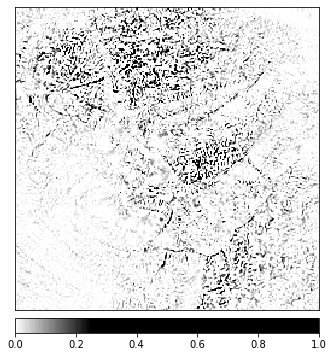

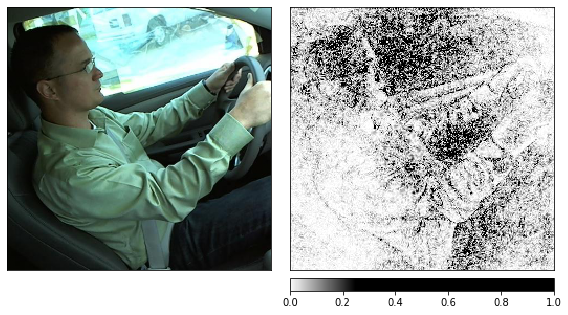

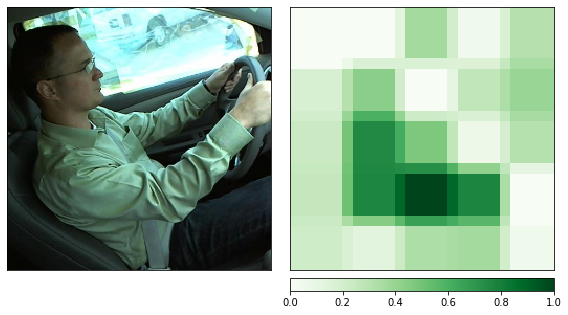


Example:  c1 - texting - right

Network Prediction: c1



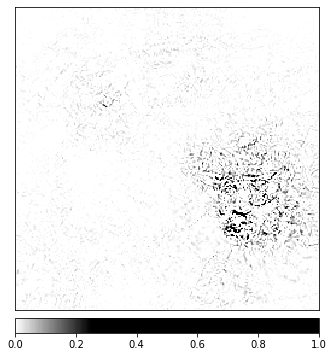

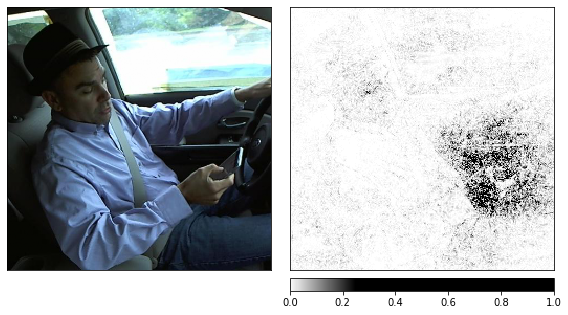

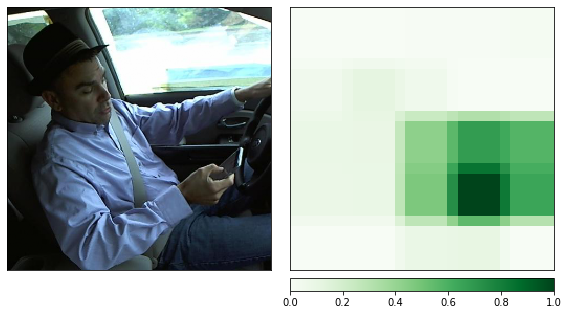


Example:  c2 - talking on the phone - right

Network Prediction: c2



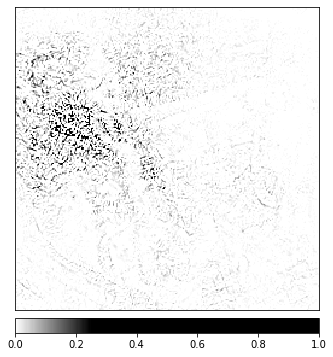

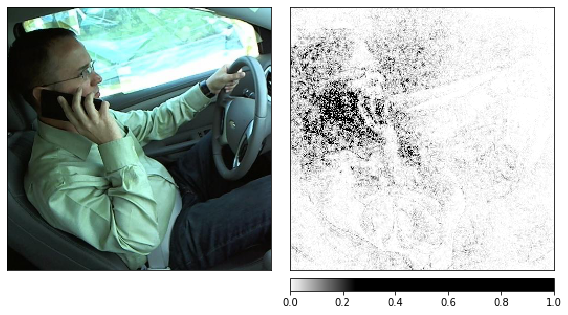

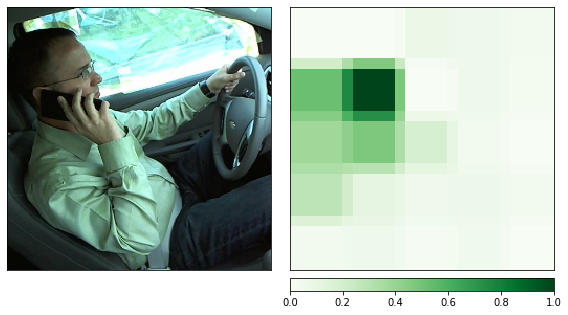


Example:  c3 - texting - left

Network Prediction: c3



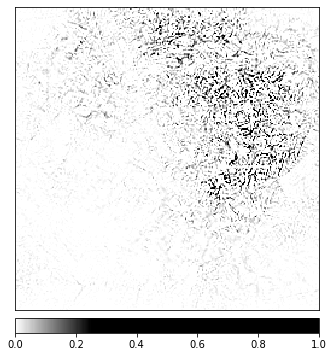

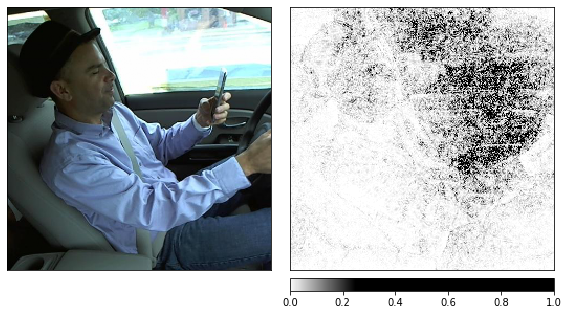

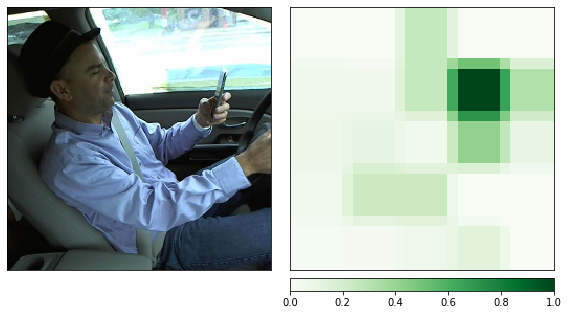


Example:  c4 - talking on the phone - left

Network Prediction: c4



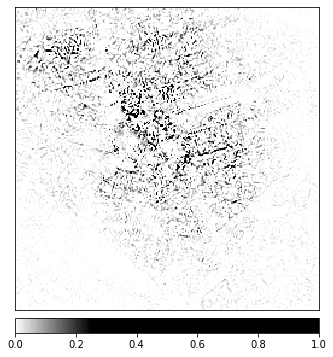

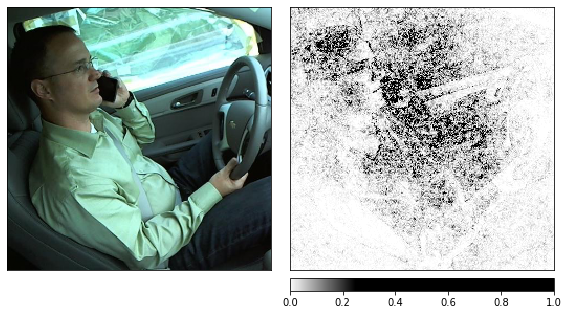

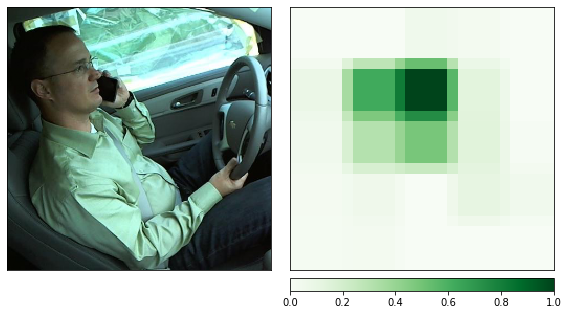


Example:  c5 - operating the radio

Network Prediction: c5



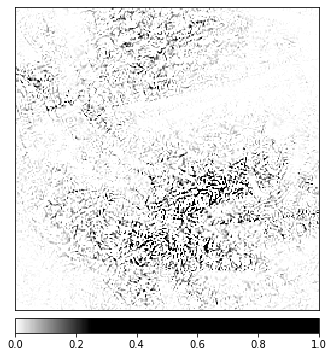

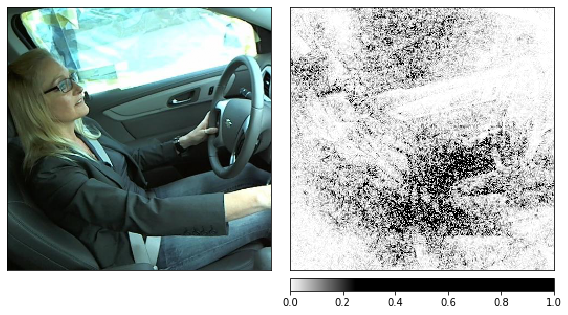

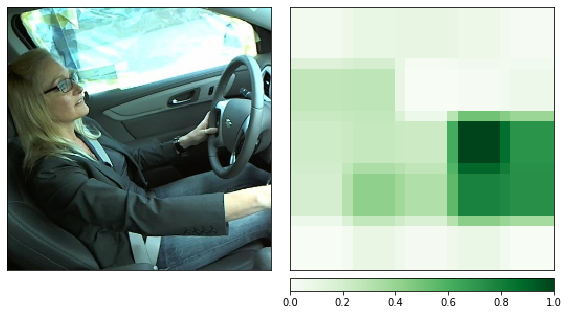


Example:  c6 - drinking

Network Prediction: c6



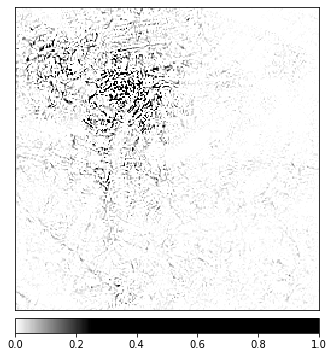

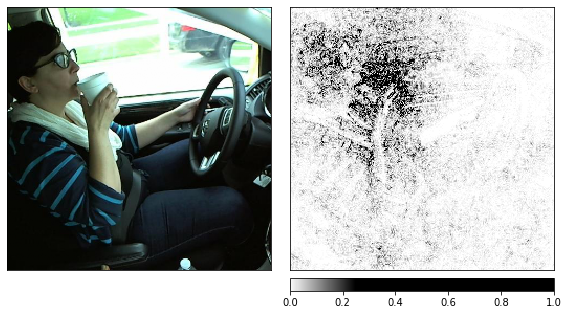

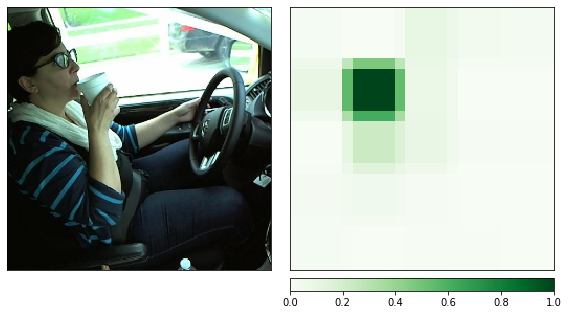


Example:  c7 - reaching behind

Network Prediction: c7



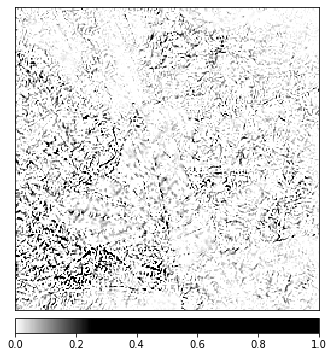

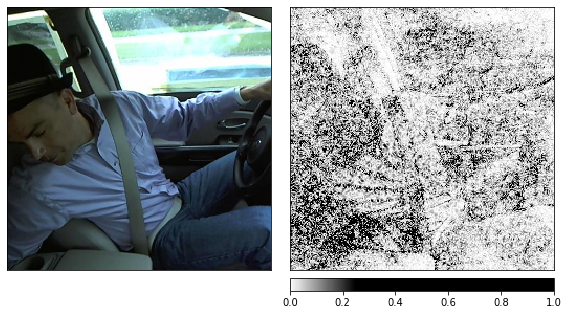

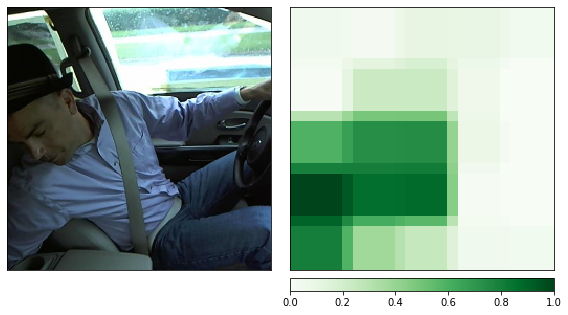


Example:  c8 - hair and makeup

Network Prediction: c8



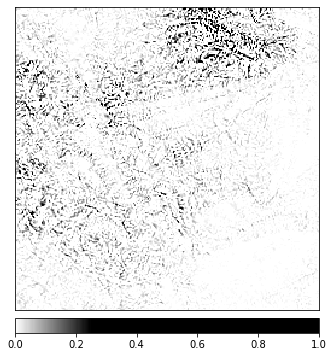

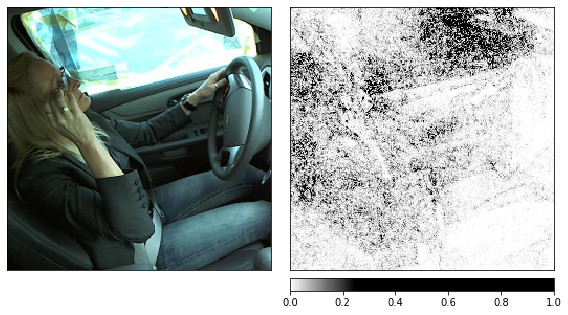

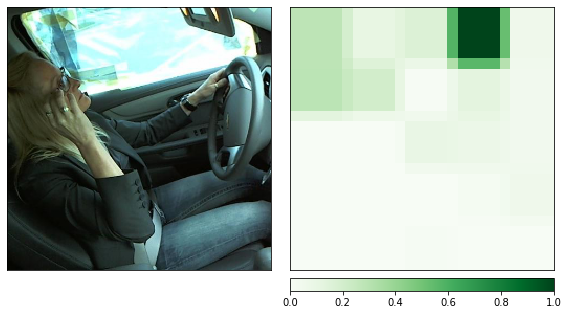

In [11]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
                                                 N=256)

# for every example create an integrated gradients, gradient shape and occlusion plot
for class_name, example_data in examples.items():
    input_img = example_data[0]
    target = torch.tensor(example_data[1].data).type(torch.uint8).to("cuda")
    
    print()
    print("Example: ", " - ".join([class_name, convert.convert_label_to_description[class_name]]))
    print()
    print("Network Prediction: {}\n".format(trained_learner.predict(example_data[0])[0]))
    
    integrated_gradients_plot(trained_learner=trained_learner, 
                              input_img=input_img, 
                              target=target, 
                              cmap=default_cmap, 
                              n_steps=100)
    
    gradient_shap_plot(trained_learner=trained_learner, 
                       input_img=input_img, 
                       target=target, 
                       cmap=default_cmap, 
                       n_samples=100)
    
    occlusion_plot(trained_learner=trained_learner, 
                   input_img=input_img, 
                   target=target)
    

By looking at the examples, we can get a better intuition on the regions the model is paying the most attention. For that matter, I found the occlusion plot to be especially useful. For example, we could see that the model is focusing on the mirror and the face of the driver for categorising "c8 - hair and makeup" or on the position of the handy for classifying "c3 - texting - left" which makes sense. I think, by cleaning up the dataset a little bit more, we could even improve this further. But all in all, I'm pleased with these results for now.

# Inspect model using shap package

It's always useful to have more than one view. So let's also investigate our model predictions using the shap package.

In [13]:
X = trained_learner.data.one_batch(DatasetType.Valid, detach=False, denorm=False, cpu=False)[0]

In [14]:
examples_as_tensor = torch.cat([trained_learner.data.one_item(value[0])[0] for value in examples.values()], 
                               dim=0).to("cuda")

In [15]:
e = shap.GradientExplainer((trained_learner.model), X)
shap_values,indexes = e.shap_values(examples_as_tensor, ranked_outputs=2, nsamples=200)

In [16]:
index_names = np.vectorize(lambda x: convert.convert_index_to_label[x])(indexes)

In [17]:
examples_as_tensor = torch.cat([value[0].data.reshape(1,3,CONFIG["img_size"],CONFIG["img_size"]) for value in examples.values()], 
                               dim=0).to("cuda")

In [18]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
to_explain_np = np.rollaxis(examples_as_tensor.cpu().numpy(), 1, 4)

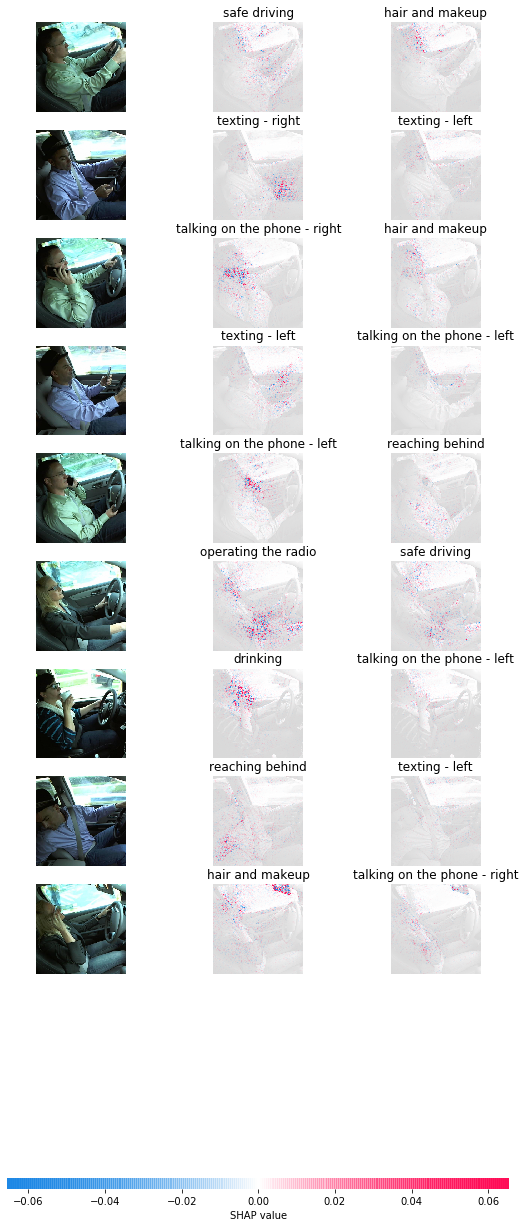

In [19]:
# plot the explanations
shap.image_plot(shap_values, to_explain_np, index_names, show=False)

I like the alternative point of view we get from the shap package. We can calculate and plot the explanations for the n highest-ranked predictions. In my case, I only wanted the top two ranked predictions, so I set ranked_outputs to 2. It's easy to see which parts of the image pushed the model to the prediction(red pixels) and which pushed the model away from the predictions(blue pixels). We can also get a better understanding of cases where the model might make mistakes. For example, in the case of safe driving, the model seems to pay attention to the position of the head pointing more or less straight forward, but the position of the head is also a significant influence in the decision for hair and makeup. 